# Catchment areas 

The objective of this notebook is to determine the catchment areas of the Transmilenio Stations 

What do they should include: 
- 1000 km buffer 
- Tiessen polygons when buffer are overlap 
- Include feeder routes catchment areas as well 

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pandas.io.sql as sqlio
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import time
import geopandas as gpd
import geoplot
from scipy.spatial import Voronoi, voronoi_plot_2d
import shapely.geometry
import shapely.ops

import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import MultiPoint, Point, Polygon
from scipy.spatial import Voronoi

import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import MultiPoint, Point, Polygon
from scipy.spatial import Voronoi
from shapely import geometry
from shapely.geometry import LineString

import requests
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import LineString

# Functions

### General

In [2]:
def plot_areas(gdf, title):
    
    fig, ax = plt.subplots(figsize=(20, 10))

    gdf.plot(ax = ax)

    x, y, arrow_length = 0.1, 0.9, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=5, headwidth=15),
                ha='left', va='top', fontsize=20,
                xycoords=ax.transAxes)

    plt.title(title)
    plt.axis('off');

### BRT functions
These buffers exclude transactions that are identified comming from feeder and inter-city services.

In [30]:
def create_buffer(stations, buffer_distance = 1800):
    """ Creates a buffer for each point if the given biffer distance. It excludes feeder and inter-city buffers. 
        Input: 
        - stations: Geopandas dataframe. Each row is a point. crs = 'EPSG:3116'
        - buffer_distance: float. Buffer distance in meters
        Returns
        - results: Geopandas dataframe, new geometry is the buffer"""
        

    gdf = stations[stations.entrance_type == 0]
    gdf['buffer'] = gdf.geometry.buffer(buffer_distance)
   
    gdf = gdf.set_geometry('buffer')
    gdf['unico'] = range(len(gdf))
    return gdf

### Voronoi functions
- Build voronoi polygon. 
- Clipped them with convex_hull buffer to close open polygons 
- Transform polygons to shapely goemtry object 
- Create a geopandas dataframe

In [4]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    
    Source: https://stackoverflow.com/questions/20515554/colorize-voronoi-diagram/20678647#20678647

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [5]:
def union(col1, col2):
    '''Pair-waise union of polygons of two GeoSeries objects'''
    
    n = len(col1)
    m = len(col2)
    
    #Assess two columns have the same lenght
    assert n == m
    
    union_list = []
    for i in range(n):
        poly1, poly2 = col1[i], col2[i]
        
        if poly1 == None:
            union_list.append(poly2)
        elif poly2 == None:
            union_list.append(poly1)
        else: 
            union = shapely.ops.unary_union([poly1, poly2])
            union_list.append(union)
    
    return gpd.GeoSeries(union_list)

In [6]:
def create_voronoi_polygon(stations):
    """
    
    Voronoi polygon creation form: 
    #Source code for this: https://stackoverflow.com/questions/34968838/python-finite-boundary-voronoi-cells
    """
    
    points = np.array(stations[stations.entrance_type == 0][['longitude','latitude']])
    assert len(points) == 151
    
    vor = Voronoi(points)
    regions, vertices = voronoi_finite_polygons_2d(vor)
    
    #Voronoi polygon creation. 
    pts = MultiPoint([Point(i) for i in points])
    mask = pts.convex_hull.buffer(0.1)
    new_vertices = []
    for region in regions:
        polygon = vertices[region]
        shape = list(polygon.shape)
        shape[0] += 1
        p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)
        poly = np.array(list(zip(p.boundary.coords.xy[0][:-1], p.boundary.coords.xy[1][:-1])))
        new_vertices.append(poly)
#         plt.fill(*zip(*poly), alpha=0.4)

#     plt.plot(points[:,0], points[:,1], 'ko')
#     plt.title("Clipped Voronois")
#     plt.show()
        
    #Building polygon shapely object 
    poly_list = []
    for poly in new_vertices:
        poly_list.append(geometry.Polygon(poly))

    #Saving polygons in a geodataframe 
    voronoi = gpd.GeoDataFrame(poly_list)
    voronoi.columns = ['geometry_voronoi']
    voronoi = gpd.GeoDataFrame(voronoi, geometry = 'geometry_voronoi', crs = 'EPSG:4686')

    #Project polygons to meters 
    voronoi = voronoi.to_crs('EPSG:3116')
    
    #Recover voronoi station_name 
    final_voronoi = gpd.sjoin(voronoi, stations[stations.entrance_type == 0], how = 'left', op = 'intersects')
#     final_voronoi = final_voronoi.set_geometry('geometry_voronoi')
    
    return final_voronoi[['station_name', 'geometry_voronoi']]

In [7]:
def clip_buffer_voronoi(buffers, voronoi):
    merge_df = buffers.merge(voronoi, on = 'station_name')

    overlays_list = []
    for i in range(len(merge_df)):
        buffer = gpd.GeoDataFrame(merge_df.iloc[i:i+1], geometry = 'buffer')
        vor = gpd.GeoDataFrame(merge_df.iloc[i:i+1], geometry = 'geometry_voronoi')

        try: 
            overlay = gpd.overlay(buffer, vor, how='intersection', )
            overlays_list.append(overlay)
        except AttributeError:
            overlays_list.append(None)

    #Concat resutls 
    areas = pd.concat(overlays_list, axis = 0)
    areas.crs = 'EPSG:3116'
    areas = areas.to_crs('EPSG:4686')
    
    
    cols = ['station_name_1', 'geometry']

    areas = areas[cols]
    areas.columns = ['station_name', "catchment_area"]
    
    return areas.set_geometry('catchment_area')

### Feeder functions

In [8]:
def feeder_buffers_areas(feeder_routes, buffer_value = 500):
    #Maps "origen ruta zonal" to id_station
    stations_map = {'PORTAL NORTE':'(02000) Cabecera Autopista Norte - alimentacion', 
                    'PORTAL USME':'(09000) Cabecera Usme - alimentacion', 
                    'PORTAL 80':'(04000) Cabecera Calle 80 - alimentacion', 
                    'PORTAL EL DORADO':'(06000) Portal Eldorado - alimentacion',
                    'PORTAL AMERICAS':'(05000) Portal Américas - alimentacion',
                    'PORTAL TUNAL':'(08000) Portal Tunal - alimentacion', 
                    'BANDERAS':'(05100) Banderas P. Central - alimentacion', 
                    'PORTAL SUBA':'(03000) Portal Suba - alimentacion',
                    'PORTAL 20 JULIO':'(10000) Portal 20 de Julio - alimentacion', 
                    'MOLINOS':'(50003) Corral Molinos', 
                    'GRANJA':'(50006) Corral Carrera 77', 
                    'PORTAL SUR':'(07000) Portal Sur - alimentacion',
                    'CALLE 40 SUR':'(50002) Corral Calle 40 Sur', 
                    'GENERAL SANTANDER':'(07006) General Santander - alimentacion', 
                    'AV CALI':'(50004) Corral Avenida Ciudad de Cali'}

    # Note: There is no information about feeder routes for "Bicentenario" station.
    # Those observations will be deleted. 

    feeder_routes['station_name'] = feeder_routes.origen_rut.replace(stations_map)
    
    #Buffer around the feeder trayectory of 500 meters 
    feeder_routes['buffer'] = feeder_routes.geometry.buffer(buffer_value)
    feeder_routes = feeder_routes.set_geometry('buffer')

    #Disolve polygons that belong to the same final destination 
    feeder_routes = feeder_routes.dissolve(by='station_name').reset_index()
    feeder_routes = feeder_routes.to_crs('EPSG:4686')
    feeder_routes = feeder_routes[['station_name','buffer']]
    
    return feeder_routes

In [9]:
def clip_feeder_area(feeder, brt):
    #Desolve main area 
    brt_copy = brt.copy()
    brt_copy['dissolve_dummy'] = 1
    dissolved = brt_copy.dissolve('dissolve_dummy')['catchment_area'][1]

    #Clipped each feeder buffer to main area
    clipped_list = []
    for polygon in feeder['buffer']:
        clip = polygon.difference(dissolved)
        clipped_list.append(clip)

    #Replace shape with the clipped area 
    feeder['buffer'] = clipped_list
    return feeder.rename(columns = {'buffer': "catchment_area"}).set_geometry("catchment_area")

In [10]:
def join_brt_feeder_catchment_areas(brt, feeder):
    
    catchment_areas = gpd.GeoDataFrame(pd.concat([brt, feeder]), 
                                       geometry = 'catchment_area')
    
    catchment_areas.crs = 'EPSG:4686'
    return catchment_areas

## Input files

In [11]:
output_path = '../data/output/'
input_path = '../data/input/'

#Stations 
cols = ['station_name','latitude', 'longitude', 'entrance_type']
stations = pd.read_csv(input_path + 'stations.csv')[cols] \
             .drop_duplicates(subset =  'station_name', keep = 'last')

feeder_routes = gpd.read_file(input_path + 'feeder_routes/feeder_routes.shp')

## Processing

In [31]:
#Transform geometry column to geometry columns
stations = gpd.GeoDataFrame(stations, 
                            geometry = gpd.points_from_xy(stations.longitude, stations.latitude), 
                            crs = 'EPSG:4686')

#Project from degress to meters 
stations = stations.to_crs('EPSG:3116')

### BRT station catchment areas 

In [32]:
#Creating buffers 
buffers = create_buffer(stations, buffer_distance = 1000)
# plot_areas(buffers, 'Catchment areas BRT Stations - Bogota')

In [33]:
#Create voronoi polygons
voronoi = create_voronoi_polygon(stations)
brt_catchment_areas = clip_buffer_voronoi(buffers, voronoi)
# plot_areas(brt_catchment_areas, title = 'Catchment areas BRT Stations - Bogota')

### Feeder catchment areas 

In [34]:
feeder_catchment_areas = feeder_buffers_areas(feeder_routes, buffer_value = 500)
feeder_catchment_areas = clip_feeder_area(feeder_catchment_areas, brt_catchment_areas)

catchment_areas = join_brt_feeder_catchment_areas(brt_catchment_areas, feeder_catchment_areas)

### Join BRT and Feeder catchmen areas 

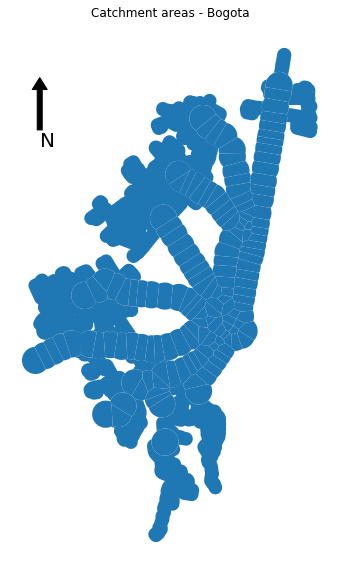

In [35]:
catchment_areas = join_brt_feeder_catchment_areas(brt_catchment_areas, feeder_catchment_areas)
plot_areas(catchment_areas, title = 'Catchment areas - Bogota')

## Saving results

In [37]:
catchment_areas
catchment_areas.to_file(output_path + 'tables/catchment_areas')